In [1]:
import pandas as pd
import sqlite3
import emoji
from collections import Counter
from bisect import bisect
import numpy as np

from matplotlib.pyplot import yscale, xscale, title, plot
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
def read_sql():
    df = __read_sql()
    df = __select_taipei_area(df)
    df = __clean_raw_dataframe(df)
    return df

# read raw data from sql
def __read_sql():
    con = sqlite3.connect('../data/InstagramPost.sqlite')
    con2 = sqlite3.connect('../data/InstagramPost2.sqlite')
    con3 = sqlite3.connect('../data/InstagramPost3.sqlite')
    SQL = pd.read_sql_query('select * from InstagramPost', con)
    SQL2 = pd.read_sql_query('select * from InstagramPost_table2', con)
    SQL3 = pd.read_sql_query('select * from InstagramPost_table3', con)
    SQL4 = pd.read_sql_query('select * from InstagramPost_table4', con)
    SQL5 = pd.read_sql_query('select * from InstagramPost_table2', con2)
    SQL6 = pd.read_sql_query('select * from InstagramPost', con3)

    # concat SQL tables
    SQL = pd.concat([SQL, SQL2, SQL3, SQL4, SQL5, SQL6]).drop_duplicates()
    del SQL2, SQL3, SQL4, SQL5, SQL6
    SQL['datetime'] = pd.to_datetime(SQL.date, unit='s')
    instagram2016 = SQL[SQL.datetime.dt.year == 2016]
    del SQL
    return instagram2016

# select taipei area
def __select_taipei_area(df):
    # 信义松山
    lat_min, lat_max = 25.028791, 25.06338
    lng_min, lng_max = 121.54733, 121.59

    df['lat'] = df.lat.astype(float)
    df['lng'] = df.lng.astype(float)

    lat_bound = df.lat.between(lat_min, lat_max)
    lng_bound = df.lng.between(lng_min, lng_max)
    df = df[lat_bound & lng_bound]
    return df

# clean datafrome
def __clean_raw_dataframe(df):
    df = df[['location_id', 'location_name', 'lat', 'lng', 'caption', 'comments',
             'date', 'media_id', 'is_video', 'likes', 'owner_id', 'thumbnail_src',
             'display_src', 'datetime']].reset_index().drop(columns='index')
    return df

In [3]:
def emoji_tokenize(text):
    token = ''.join(c for c in text if c in emoji.UNICODE_EMOJI)
    return token

def count_emoji(text, freq):
    '''
    return the highest used emoji
    it only works for text including emoji only
    '''
    emoji = emoji_tokenize(text)
    c = Counter(emoji)
    return c.most_common(freq)

In [15]:
# reMap
def reSample(x, *xkey):
    x = bisect(xkey, x)
    x = xkey[x-1]
    return x

def get_xkey(df, column='lat', resolution=30):
    '''
    resolution -> how many division you need to divide into
    '''
    xmin = df[column].min()
    xmax = df[column].max()
    xkey = np.linspace(xmin, xmax, resolution)
    return xkey

def generate_grid(df):
    # get grid
    latKey = get_xkey(df, 'lat')
    lngKey = get_xkey(df, 'lng')
    
    # resample the coordinate
    df['X'] = df['lat'].apply(lambda x: reSample(x, *latKey))
    df['Y'] = df['lng'].apply(lambda x: reSample(x, *lngKey))
    
    df_count = df[['X', 'Y']]
    xygroup = df_count.groupby(['X', 'Y'])
    return xygroup


def draw_heatmap(xygroup):
    gridCounting = xygroup.size().unstack(fill_value=0).sort_index(ascending=False)
    plt.rcParams['figure.figsize']=(14,7)
    sns.heatmap(gridCounting, cmap='Reds')
    
def export_heatmap_csv(xygroup, fname):
    grid = pd.DataFrame(xygroup.size().reset_index()).rename(columns={0: 'value'})
    grid.to_csv('%s.csv' % fname, encoding='utf8')
    
def find_emoji(emoji_face, fname):
    emoji = (ig2016[ ig2016['emoji'] == emoji_face ]
             .reset_index()
             .drop(columns=['index']))
    emoji_xy = generate_grid(emoji)
#     export_heatmap_csv(emoji_xy, fname)
    draw_heatmap(emoji_xy)

# 1. Tokenize Emoji

In [5]:
ig2016 = read_sql()
ig2016['emoji'] = ig2016['caption'].apply( lambda x: count_emoji(x, 1) )

ig2016['emoji'] = ig2016['emoji'].apply( lambda x: x[0][0] if x else None )

ig2016 = ig2016.dropna(how='any').reset_index().drop(columns=['index'])

ig2016 = ig2016[[ 'location_id', 'location_name', 'lat', 'lng',
                  'datetime', 'emoji']]

In [6]:
ig2016.head()

,location_id,location_name,lat,lng,datetime,emoji
0,1030274404,珍妮姐姐,25.033070,121.574303,2016-10-29 06:31:38,🎃
1,1019607899,三楊汽車,25.054525,121.569865,2016-10-27 08:51:02,💞
2,234730813277267,東生美食,25.040886,121.584975,2016-06-21 22:35:35,😋
3,1033086929,時冶設計,25.036978,121.580635,2016-04-13 16:24:58,🎞
4,982212735175733,POLA 特約店－媚莉,25.049360,121.557693,2016-05-06 06:58:48,💆


In [7]:
ig2016.groupby('emoji').size().sort_values(ascending=False)[:10]

emoji
❤    26020
😂    21152
😋    16667
😍    12877
💕    11820
👍     7377
🎄     6639
😭     6241
✨     5695
😘     5553
dtype: int64

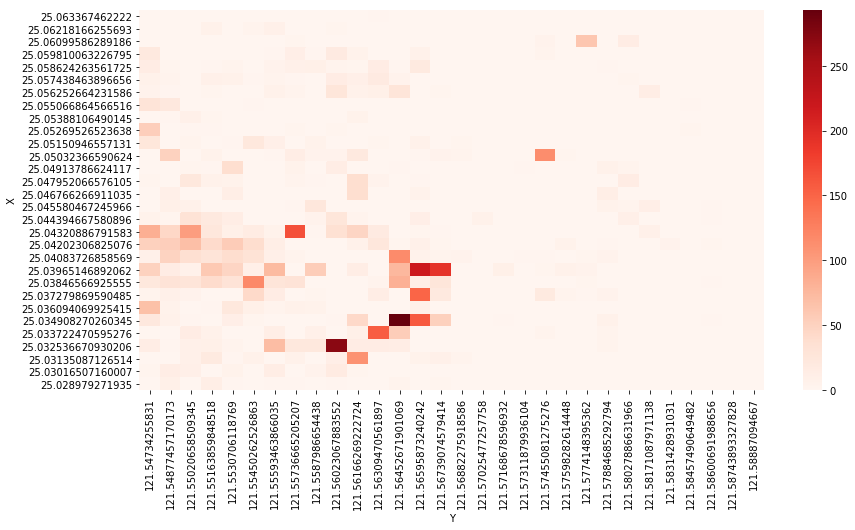

In [8]:
find_emoji('😭', 'sad')

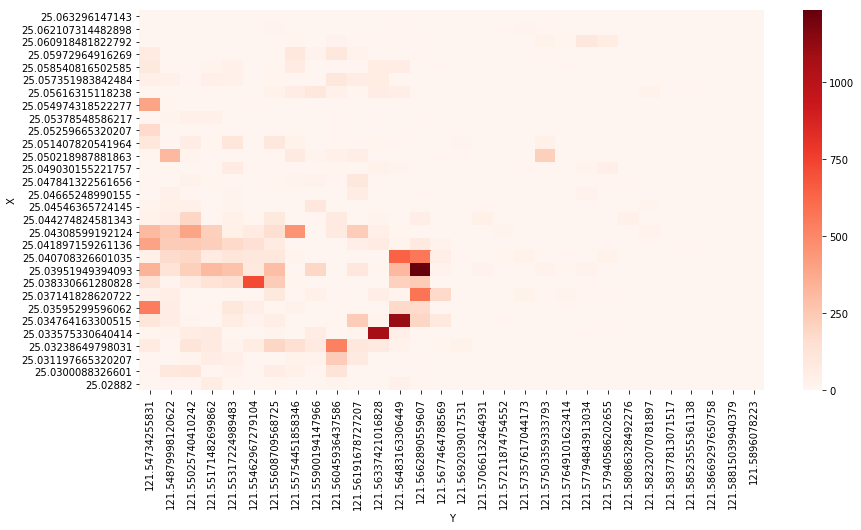

In [9]:
find_emoji('❤', 'heart')

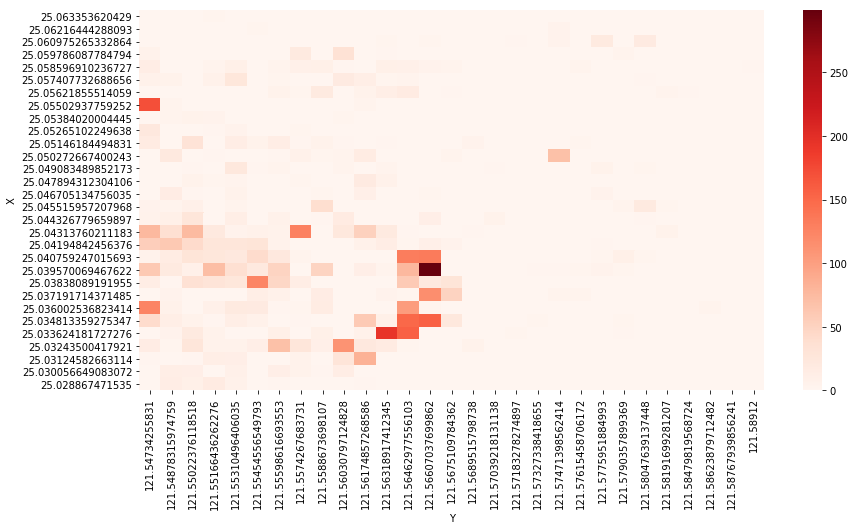

In [10]:
find_emoji('✨', 'star')

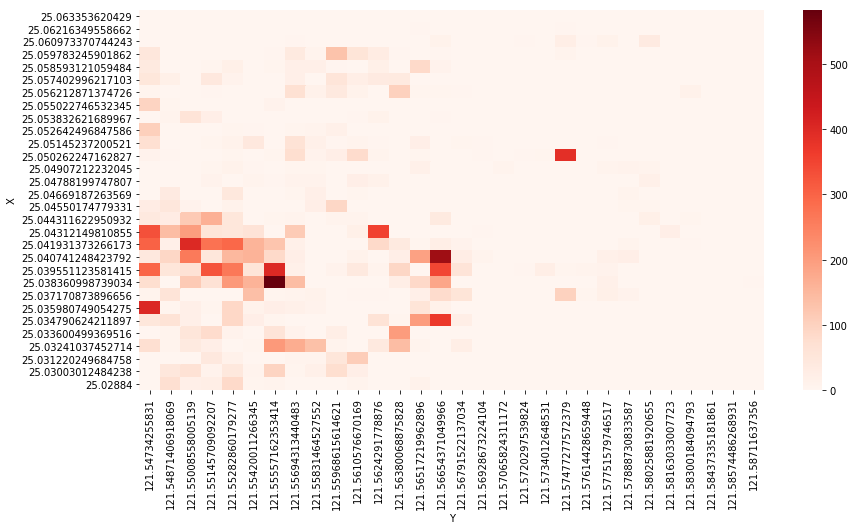

In [11]:
find_emoji('😋', 'delicious')

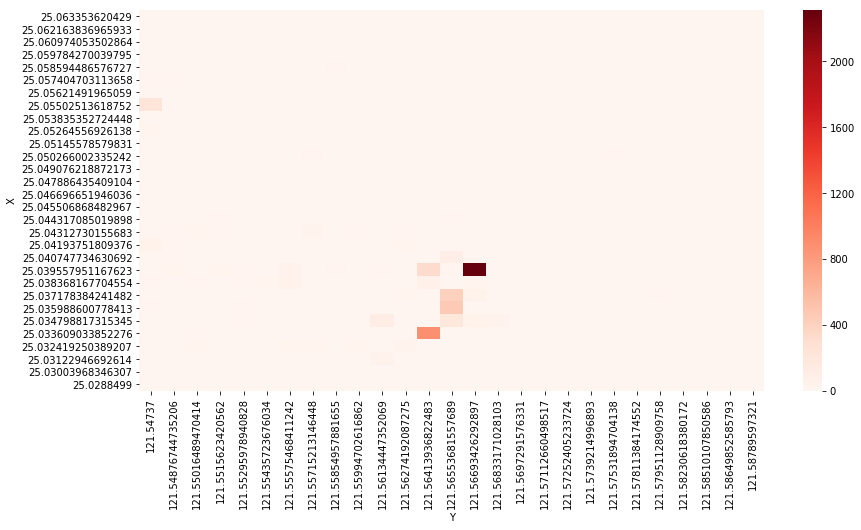

In [12]:
find_emoji('🎄', 'tree')

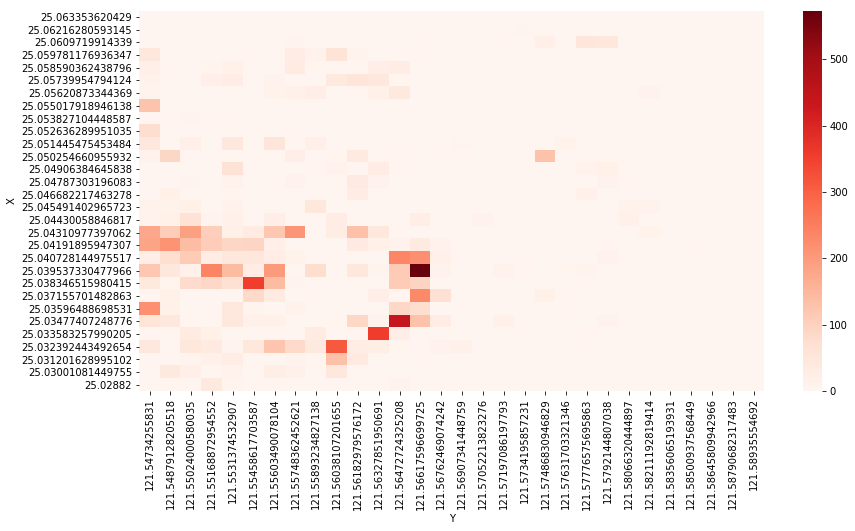

In [13]:
find_emoji('💕', 'doubleHeart')

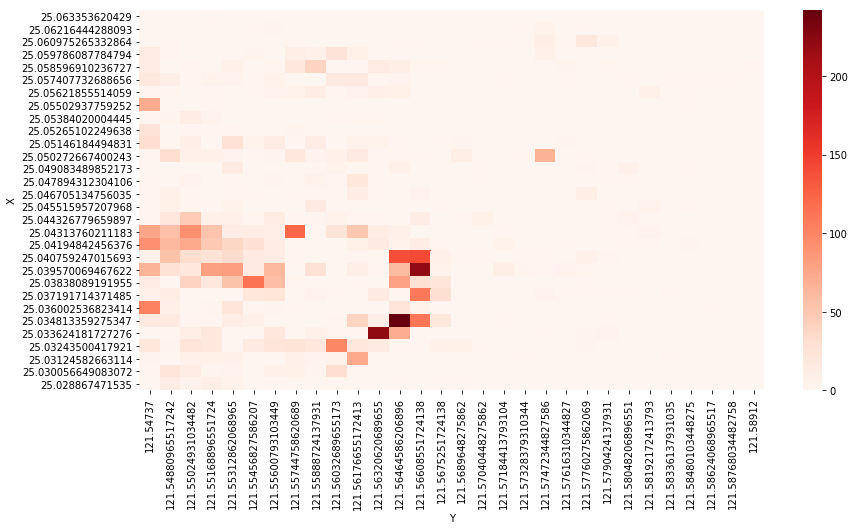

In [14]:
find_emoji('😘', 'spitHeart')

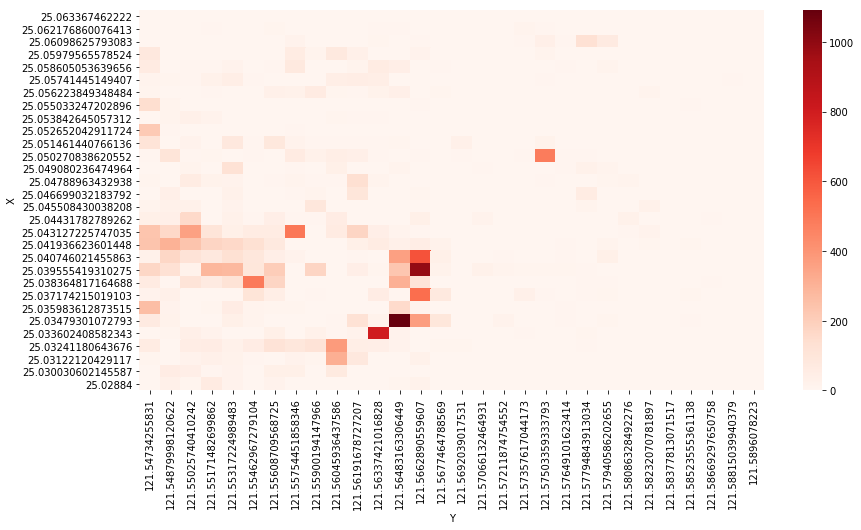

In [16]:
find_emoji('😂', 'lol')